### Tên: Nguyễn Thượng Phúc
### MSSV: 22521134

In [ ]:
import pandas as pd
import math
import numpy as np

import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import joblib

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Hàm đánh giá kết quả dự đoán của model
def evaluate(y_true, y_pred):
    acc =  metrics.accuracy_score(y_true, y_pred)
    pre = metrics.precision_score(y_true, y_pred, average='macro')
    re = metrics.recall_score(y_true, y_pred, average='macro')
    f1 = metrics.f1_score(y_true, y_pred, average='macro')

    acc = round(acc, 2)
    pre = round(pre, 2)
    re = round(re, 2)
    f1 = round(f1, 2)

    print(f"Accuracy: {acc}")
    print(f"Precision: {pre}")
    print(f"Recall: {re}")
    print(f"F1-score: {f1}")

    #print(metrics.classification_report(y_true, y_pred))
    print()
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='pred')
    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16}, fmt='.3f')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Hàm bỏ dữ liệu học kỳ cuối
def drop_last_sem(df):
  drl_cols = [col for col in df.columns if col.endswith('_drl') ]
  dtbhk_cols = [col for col in df.columns if col.endswith('_dtbhk') ]
  sotchk_cols = [col for col in df.columns if col.endswith('_sotchk') ]
  for index, row in df.iterrows():
    for idx, val in enumerate(row[dtbhk_cols]): # 1->12
      last_sem = idx
      drl_name = drl_cols[last_sem]
      dtbhk_name = dtbhk_cols[last_sem]
      sotchk_name = sotchk_cols[last_sem]

      if pd.isna(val):
        break

    if pd.isna(row[drl_name]) and pd.isna(row[dtbhk_name]) and pd.isna(row[sotchk_name]):
      sem_to_drop = last_sem-1
      drl_name = drl_cols[sem_to_drop]
      dtbhk_name = dtbhk_cols[sem_to_drop]
      sotchk_name = sotchk_cols[sem_to_drop]

    df.at[index, drl_name] = np.nan
    df.at[index, dtbhk_name] = np.nan
    df.at[index, sotchk_name] = np.nan
  return df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Hàm chuẩn hóa dữ liệu cho cột
def normalize_column(df, column_names):
  for col in column_names:
        # Convert column to numeric values, coercing any errors (non-numeric values) to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Check if the column contains all NaN values (skip normalization if true)
        if df[col].isna().all():
            print(f"Skipping normalization for column '{col}' because it contains all NaN values.")
            continue

        # Min and max for the column, excluding NaN values (use `skipna=True`)
        min_val = df[col].min()
        max_val = df[col].max()

        # Prevent division by zero if min == max (which happens when all non-NaN values are identical)
        if min_val == max_val:
            print(f"Skipping normalization for column '{col}' because all non-NaN values are identical.")
            continue

        # Apply normalization formula, ignoring NaNs in the calculation
        df[col] = (df[col] - min_val) / (max_val - min_val)

  return df

# Hàm tính thuộc tính SLOPE
def calculate_slope(scores):
    # Filter out NaN values and their corresponding indices
    valid_scores = [(i, score) for i, score in enumerate(scores) if not np.isnan(score)]

    # If there are less than two valid scores, return NaN because you can't calculate a slope
    if len(valid_scores) < 2:
        return np.nan

    # Unzip the valid (non-NaN) scores and their corresponding indices
    x = np.array([i for i, _ in valid_scores]).reshape(-1, 1)  # Indices (semester)
    y = np.array([score for _, score in valid_scores])  # Scores

    # Fit a linear regression model to get the slope
    model = LinearRegression()
    model.fit(x, y)

    return model.coef_[0]  # Return the slope



In [ ]:
from sklearn.cluster import KMeans
# Hàm tính thuộc tính PerformanceCluster
def calculate_perfCluster(df, columns, save=True):

  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(df[columns])

  kmeans = KMeans(n_clusters=3, random_state=42) # how to choose number of clusters?
  df['performance_cluster'] = kmeans.fit_predict(scaled_data)
  if save:
    joblib.dump(scaler, 'scaler_cluster.pkl')
    joblib.dump(kmeans, 'kmeans_perfCluster.pkl')
  return df

In [ ]:
# Hàm feature engineering trên bộ dữ liệu
def feature_engineering(df):
  w_dtbhk = 0.5
  w_sotchk = 0.3
  w_drl = 0.2

  dtbhk_cols = [col for col in df.columns if col.endswith('_dtbhk') ]
  sotchk_cols = [col for col in df.columns if col.endswith('_sotchk') ]
  drl_cols = [col for col in df.columns if col.endswith('_drl') ]

# Convert all relevant columns to numeric values, coercing errors to NaN
  df[dtbhk_cols] = df[dtbhk_cols].apply(pd.to_numeric, errors='coerce')
  df[sotchk_cols] = df[sotchk_cols].apply(pd.to_numeric, errors='coerce')
  df[drl_cols] = df[drl_cols].apply(pd.to_numeric, errors='coerce')

  df['AverageDTBHK'] = df[dtbhk_cols].mean(axis=1, skipna=True)
  df['AverageSOTCHK'] = df[sotchk_cols].mean(axis=1, skipna=True)
  df['AverageDRL'] = df[drl_cols].mean(axis=1, skipna=True)
  df['NumSems'] = df[dtbhk_cols].notna().sum(axis=1)

  print('*'*16)
  print('Calculate Average done!')

  segment_cols = ['AverageDTBHK','AverageSOTCHK','AverageDRL', 'NumSems']
  df = calculate_perfCluster(df, segment_cols)

  print('*'*16)
  print('Calculate PerfCluster done!')

  df['WeightedPerformance'] = (w_dtbhk*df['AverageDTBHK'] + w_sotchk*df['AverageSOTCHK'] + w_drl*df['AverageDRL'])/(w_dtbhk+w_sotchk+w_drl)

  df['SlopeDTBHK'] = df.apply(lambda row: calculate_slope(row[dtbhk_cols]), axis=1)
  df['SlopeSOTCHK'] = df.apply(lambda row: calculate_slope(row[sotchk_cols]), axis=1)
  df['SlopeDRL'] = df.apply(lambda row: calculate_slope(row[drl_cols]), axis=1)

  print('*'*16)
  print('Calculate Performance done!')

  df['StabilityDTBHK'] = df[dtbhk_cols].std(axis=1, skipna=True)
  df['StabilitySOTCHK'] = df[sotchk_cols].std(axis=1, skipna=True)
  df['StabilityDRL'] = df[drl_cols].std(axis=1, skipna=True)

  print('*'*16)
  print('Calculate Stability done!')

  df['SlopeToStabilityDTBHK'] = df['SlopeDTBHK'] / df['StabilityDTBHK']
  df['SlopeToStabilitySOTCHK'] = df['SlopeSOTCHK'] / df['StabilitySOTCHK']
  df['SlopeToStabilityDRL'] = df['SlopeDRL'] / df['StabilityDRL']

  print('*'*16)
  print('Calculate SlopeToAverage done!')

  return df.drop(dtbhk_cols+sotchk_cols+drl_cols, axis=1)



In [ ]:
train_file = 'train_data.csv'
test_file = 'test_data.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [ ]:
# Các cột biến phân loại và biến liên tục
cat_features=['CCHV_1', 'CCHV_2', 'CCHV_3', 'CCHV_4', 'CCHV_5', 'CCHV_6', 'pass_avsc']
num_features = [col for col in train_data.columns if col not in cat_features]
num_features.remove('label')

In [ ]:
%%time
# Chuyển đổi giá trị NaN thành string
train_data = train_data.fillna('').astype(str)
test_data = test_data.fillna('').astype(str)

# Chuẩn hóa dữ liệu và bỏ dữ liệu học kỳ cuối ở tập train
train_data = normalize_column(train_data, num_features)
test_data = normalize_column(test_data, num_features)
train_data = drop_last_sem(train_data)

# Feature engineering trên tập train và test
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

Skipping normalization for column 'HK12_dtbhk' because it contains all NaN values.
Skipping normalization for column 'HK12_sotchk' because it contains all NaN values.
Skipping normalization for column 'HK12_dtbhk' because it contains all NaN values.
Skipping normalization for column 'HK12_sotchk' because it contains all NaN values.
****************
Calculate Average done!
****************
Calculate PerfCluster done!
****************
Calculate Performance done!
****************
Calculate Stability done!
****************
Calculate SlopeToAverage done!
****************
Calculate Average done!
****************
Calculate PerfCluster done!
****************
Calculate Performance done!
****************
Calculate Stability done!
****************
Calculate SlopeToAverage done!
CPU times: user 15.2 s, sys: 230 ms, total: 15.4 s
Wall time: 19.1 s


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Sử dụng LabelEncoder để mã hóa thuộc tính CCHV1->6 và Pass_avsc
cchv_le = LabelEncoder()
cchv_le.fit(train_data[['CCHV_1']].values.ravel())

for cl in cat_features:
  if cl != 'pass_avsc':
    train_data[cl] = cchv_le.transform(train_data[cl].astype('O'))
    test_data[cl] = cchv_le.transform(test_data[cl].astype('O'))

avsc_le = LabelEncoder()
avsc_le.fit(train_data['pass_avsc'].values.ravel())
train_data['pass_avsc'] = avsc_le.transform(train_data['pass_avsc'].astype('O'))
test_data['pass_avsc'] = avsc_le.transform(test_data['pass_avsc'].astype('O'))

joblib.dump(cchv_le, 'cchv_le.pkl')
joblib.dump(avsc_le, 'avsc_le.pkl')


['avsc_le.pkl']

In [ ]:
avsc_le.classes_

array(['', 'False', 'True'], dtype=object)

In [ ]:
cchv_le.classes_

array(['', 'Bị cảnh cáo vì ĐTB 2 học kỳ liên tiếp < 4',
       'Bị cảnh cáo vì ĐTB học kỳ', 'Bị cảnh cáo vì ĐTB và trễ học phí',
       'Bị cảnh cáo vì đóng học phí trễ', 'Được xem xét hạ mức'],
      dtype=object)

In [ ]:
test_data['pass_avsc']

,pass_avsc
0,0
1,0
2,0
3,0
4,2
...,...
796,0
797,0
798,0
799,0


In [ ]:
test_data['CCHV_1'].value_counts()

,count
CCHV_1,
0,657
2,92
4,24
3,15
5,9
1,3


In [ ]:
# Xác định các cột là feature và cột label
features_cols = train_data.columns[1:]
target_col = train_data.columns[0]

In [ ]:
num_cols = features_cols.drop(cat_features)

In [ ]:
train_data = train_data.dropna()
test_data = test_data.dropna()

print(f"train_data shape: {train_data.shape}")
print(f"test_data shape: {test_data.shape}")

train_data shape: (1803, 23)
test_data shape: (800, 23)


In [ ]:
import pickle
# Chuẩn hóa dữ liệu sau khi feature engineering
train_data = normalize_column(train_data, num_cols)
test_data = normalize_column(test_data, num_cols)

<ipython-input-3-896e09bfda93>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
<ipython-input-3-896e09bfda93>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - min_val) / (max_val - min_val)
<ipython-input-3-896e09bfda93>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [ ]:
# Chia tập X,y cho train và test
X_train = train_data[features_cols]
y_train = train_data[target_col]

X_test = test_data[features_cols]
y_test = test_data[target_col]

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1803, 22)
y_train shape: (1803,)
X_test shape: (800, 22)
y_test shape: (800,)


In [ ]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [ ]:
X_test.columns

Index(['pass_avsc', 'CCHV_1', 'CCHV_2', 'CCHV_3', 'CCHV_4', 'CCHV_5', 'CCHV_6',
       'AverageDTBHK', 'AverageSOTCHK', 'AverageDRL', 'NumSems',
       'performance_cluster', 'WeightedPerformance', 'SlopeDTBHK',
       'SlopeSOTCHK', 'SlopeDRL', 'StabilityDTBHK', 'StabilitySOTCHK',
       'StabilityDRL', 'SlopeToStabilityDTBHK', 'SlopeToStabilitySOTCHK',
       'SlopeToStabilityDRL'],
      dtype='object')

In [ ]:
from sklearn.model_selection import GridSearchCV

[Evaluation Before GridSearchCV]
Accuracy: 0.87
Precision: 0.85
Recall: 0.86
F1-score: 0.86



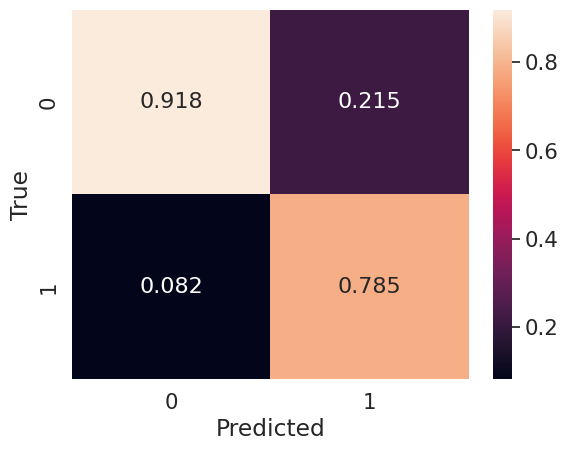

Performing GridSearchCV...
Best Parameters: {'criterion': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
[Evaluation After GridSearchCV]
Accuracy: 0.9
Precision: 0.89
Recall: 0.87
F1-score: 0.88



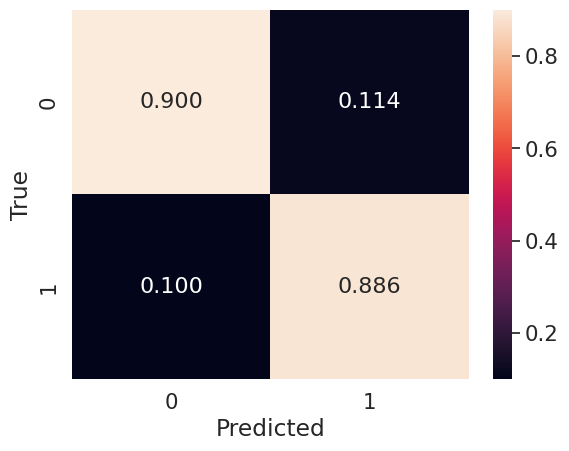

Best model saved successfully!


In [ ]:
# HUẤN LUYỆN MÔ HÌNH DECISION TREE CLASSIFIER
model = DecisionTreeClassifier()  # Default parameters
model.fit(X_train, y_train)

# Evaluate the model before hyperparameter tuning
pred = model.predict(X_test)
print("[Evaluation Before GridSearchCV]")
evaluate(y_test, pred)

# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Criteria for splitting
    'max_depth': [None, 5, 10, 20, 50],            # Maximum depth of tree
    'min_samples_split': [2, 5, 10],               # Minimum samples required to split
    'min_samples_leaf': [1, 2, 5],                 # Minimum samples required at a leaf
}

# Initialize GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
print("Performing GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluate the best model after hyperparameter tuning
best_model = grid_search.best_estimator_
pred_after = best_model.predict(X_test)
print("[Evaluation After GridSearchCV]")
evaluate(y_test, pred_after)

# Save the best model to a file
joblib.dump(best_model, 'DecisionTree_best.pkl')
print("Best model saved successfully!")

[Evaluation Before GridSearchCV]
Accuracy: 0.9
Precision: 0.89
Recall: 0.89
F1-score: 0.89



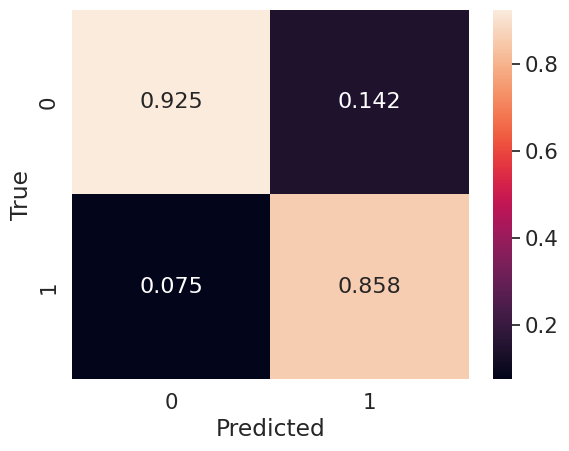

Performing GridSearchCV...
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
[Evaluation After GridSearchCV]
Accuracy: 0.9
Precision: 0.89
Recall: 0.89
F1-score: 0.89



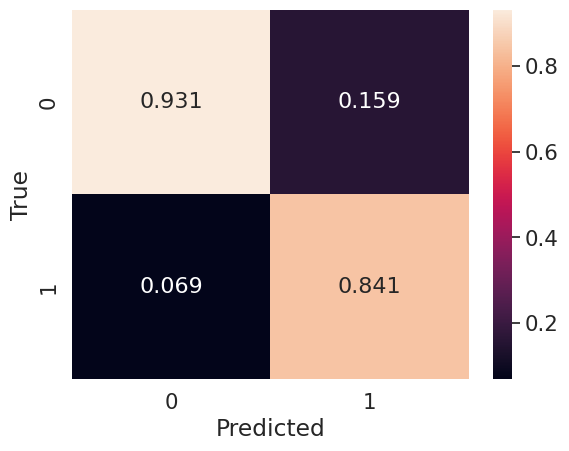

Best model saved successfully!


In [ ]:
from sklearn.svm import SVC
# HUẤN LUYỆN MÔ HÌNH SVM

svm_model = SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced')
svm_model.fit(X_train, y_train)

pred = svm_model.predict(X_test)
print("[Evaluation Before GridSearchCV]")
evaluate(y_test, pred)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],               # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernel types
    'gamma': ['scale', 'auto'],           # Kernel coefficient
    'degree': [2, 3, 4],                  # Degree for polynomial kernel
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
print("Performing GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and best model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = grid_search.best_estimator_

# Evaluate the best model after hyperparameter tuning
pred_after = best_model.predict(X_test)
print("[Evaluation After GridSearchCV]")
evaluate(y_test, pred_after)

# Save the best model to a file
joblib.dump(best_model, 'SVM_best.pkl')
print("Best model saved successfully!")

[Evaluation Before GridSearchCV]
Accuracy: 0.9
Precision: 0.9
Recall: 0.88
F1-score: 0.89



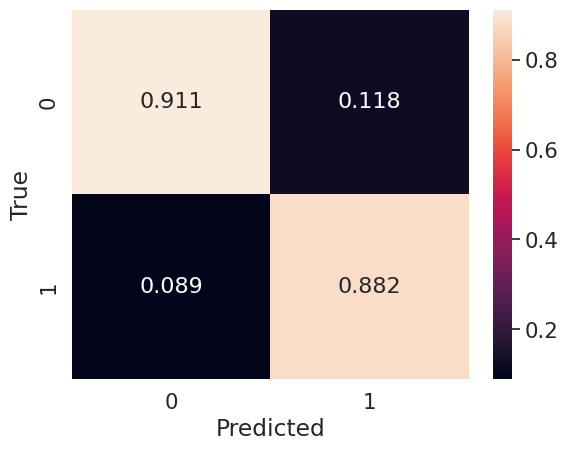

Performing GridSearchCV...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
[Evaluation After GridSearchCV]
Accuracy: 0.9
Precision: 0.89
Recall: 0.88
F1-score: 0.88



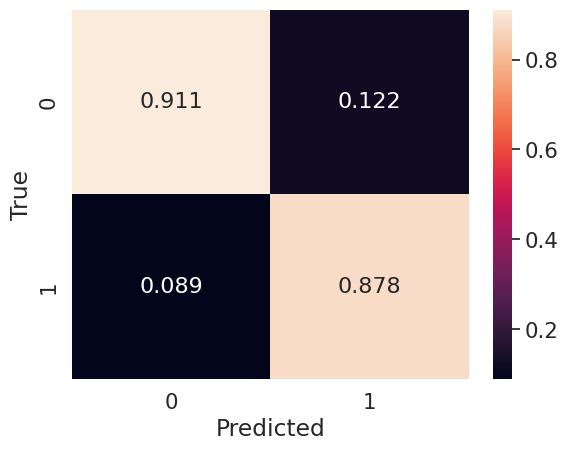

Best model saved successfully!


In [ ]:
# HUẤN LUYỆN MÔ KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

pred= model.predict(X_test)

print("[Evaluation Before GridSearchCV]")
evaluate(y_test, pred)

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
print("Performing GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluate the best model after hyperparameter tuning
best_model = grid_search.best_estimator_
pred_after = best_model.predict(X_test)

print("[Evaluation After GridSearchCV]")
evaluate(y_test, pred_after)

# Save the best model to a file
joblib.dump(best_model, 'KNeighbour_best.pkl')
print("Best model saved successfully!")

[Evaluation Before GridSearchCV]
Accuracy: 0.89
Precision: 0.87
Recall: 0.87
F1-score: 0.87



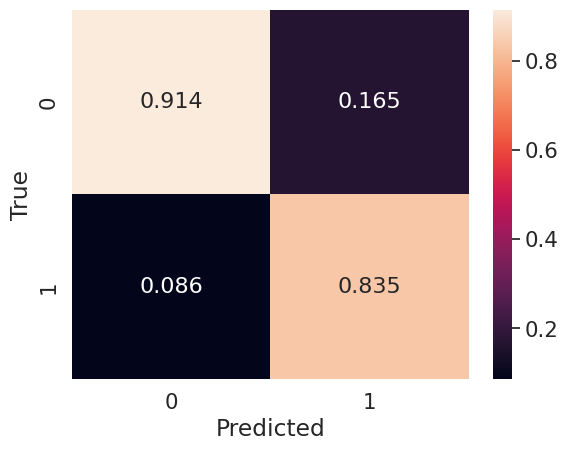

Performing GridSearchCV...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
[Evaluation After GridSearchCV]
Accuracy: 0.89
Precision: 0.88
Recall: 0.88
F1-score: 0.88



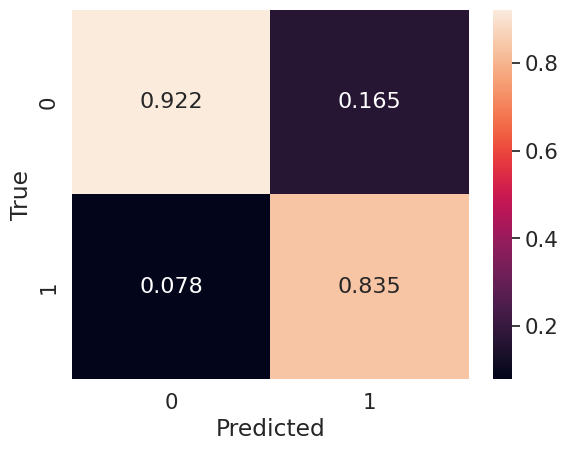

Best model saved successfully!


In [ ]:
# # HUẤN LUYỆN MÔ HÌNH Logistic Regression
from sklearn.linear_model import LogisticRegression
# Logistic Regression with L2 Regularization (Ridge)
model = LogisticRegression(solver='liblinear', penalty='l2', random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate the default model
pred = model.predict(X_test)
print("[Evaluation Before GridSearchCV]")
evaluate(y_test, pred)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength (inverse of lambda)
    'solver': ['liblinear', 'lbfgs'],   # Solver options (liblinear is good for small datasets)
    'penalty': ['l1', 'l2'],            # Regularization type (L1 = Lasso, L2 = Ridge)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
print("Performing GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and best model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = grid_search.best_estimator_

# Evaluate the best model after hyperparameter tuning
pred_after = best_model.predict(X_test)
print("[Evaluation After GridSearchCV]")
evaluate(y_test, pred_after)

# Save the best model to a file
joblib.dump(best_model, 'LogisticRegression_best.pkl')
print("Best model saved successfully!")

Training Random Forest with default parameters...
[Evaluation Before GridSearchCV]
Accuracy: 0.92
Precision: 0.92
Recall: 0.88
F1-score: 0.9



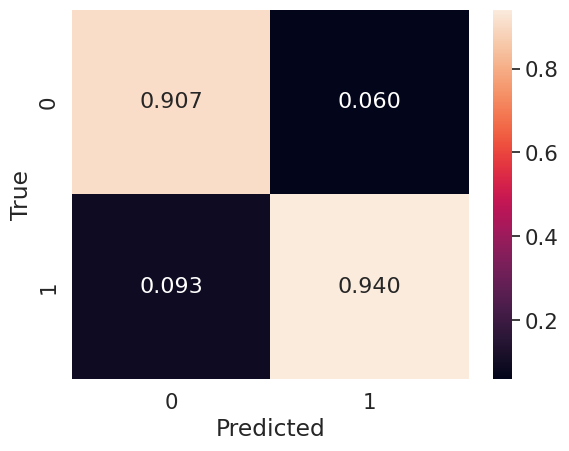

Performing GridSearchCV...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
[Evaluation After GridSearchCV]
Accuracy: 0.92
Precision: 0.91
Recall: 0.9
F1-score: 0.9



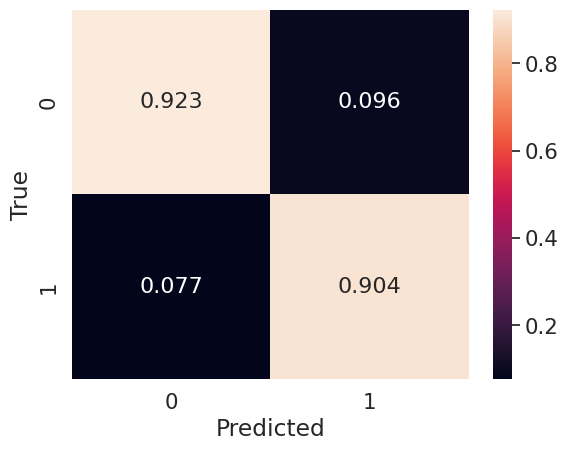

Best model saved successfully!


In [ ]:
# HUẤN LUYỆN MÔ HÌNH RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# Initial model training (before GridSearchCV)
print("Training Random Forest with default parameters...")
model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the default model
pred = model.predict(X_test)
print("[Evaluation Before GridSearchCV]")
evaluate(y_test, pred)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],     # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],    # Maximum depth of trees
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum samples required to be a leaf
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
print("Performing GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and best model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = grid_search.best_estimator_

# Evaluate the best model after hyperparameter tuning
pred_after = best_model.predict(X_test)
print("[Evaluation After GridSearchCV]")
evaluate(y_test, pred_after)

# Save the best model to a file
joblib.dump(best_model, 'RandomForest_best.pkl')
print("Best model saved successfully!")

Training LightGBM with default parameters...
[LightGBM] [Info] Number of positive: 543, number of negative: 1260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3346
[LightGBM] [Info] Number of data points in the train set: 1803, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301165 -> initscore=-0.841758
[LightGBM] [Info] Start training from score -0.841758
[Evaluation Before GridSearchCV]
Accuracy: 0.91
Precision: 0.91
Recall: 0.89
F1-score: 0.9



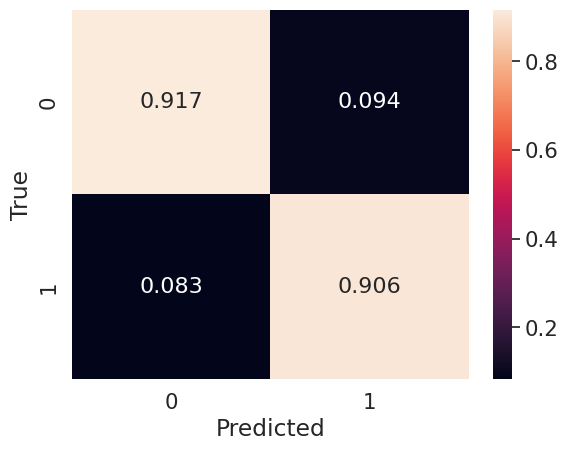

Best model saved successfully!
Performing GridSearchCV...


KeyboardInterrupt: 

In [ ]:
# HUẤN LUYỆN MÔ HÌNH LightGBM
import lightgbm as lgb

# Initial model training (before GridSearchCV)
print("Training LightGBM with default parameters...")
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the default model
pred = model.predict(X_test)
print("[Evaluation Before GridSearchCV]")
evaluate(y_test, pred)

# Save the best model to a file
joblib.dump(model, 'light_gbm.pkl')
print("Best model saved successfully!")


# Define the parameter grid for GridSearchCV
param_grid = {
    'num_leaves': [31, 50, 70],          # Maximum number of leaves in one tree
    'max_depth': [-1, 10, 20],          # Maximum tree depth (-1 means no limit)
    'learning_rate': [0.01, 0.05, 0.1], # Learning rate
    'n_estimators': [100, 200, 500],    # Number of boosting iterations
    'subsample': [0.8, 1.0],            # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0],     # Subsample ratio of columns when constructing each tree
}

# Initialize GridSearchCV
grid_search = GridSearchCV(lgb.LGBMClassifier(random_state=42),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
print("Performing GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and best model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = grid_search.best_estimator_

# Evaluate the best model after hyperparameter tuning
pred_after = best_model.predict(X_test)
print("[Evaluation After GridSearchCV]")
evaluate(y_test, pred_after)

# Save the best model to a file
joblib.dump(best_model, 'light_gbm_best.pkl')
print("Best model saved successfully!")